## Gaussian Process 

* Import from EFPPO

In [1]:
import functools as ft
import pathlib

import ipdb
import jax
import jax.random as jr
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np
import typer
from loguru import logger

import efppo.run_config.f16
from efppo.task.f16 import F16GCASFloorCeil
from efppo.task.f16_safeguarded import MORELLI_BOUNDS, F16Safeguarded

from efppo.rl.collector import RolloutOutput, collect_single_mode
from efppo.rl.efppo_inner import EFPPOInner
from efppo.rl.rootfind_policy import Rootfinder, RootfindPolicy
from efppo.task.plotter import Plotter
from efppo.utils.ckpt_utils import get_run_dir_from_ckpt_path, load_ckpt_ez
from efppo.utils.jax_utils import jax2np, jax_vmap, merge01
from efppo.utils.logging import set_logger_format
from efppo.utils.path_utils import mkdir

from gp_cbf.src.f16 import F16GCASFloorCeilDisturbed

from itertools import product




2024-06-25 14:17:49.725253: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


### Define function

In [2]:
def generate_rollouts(task, alg, rootfind_pol, x0s = [],z0s = [], T = 512) -> RolloutOutput:
    # Roll out episode length
    rollout_T = T
 
    ## Collect trajectory
    collect_fn = ft.partial(
            collect_single_mode,
            task,
            get_pol=rootfind_pol,
            disc_gamma=alg.disc_gamma,
            z_min=alg.z_min,
            z_max=alg.z_max,
            rollout_T=rollout_T,
        )
        
    vmap_fn = jax.jit(jax_vmap(collect_fn, rep=1))
    bb_rollout: RolloutOutput = jax2np(vmap_fn(x0s, z0s)) 
    return bb_rollout

def plot_rollouts(plotter, bb_rollout, fig_name=None):
    ###############################3
    # Plot. 
    figsize = np.array([2.8, 2.2])
    fig, ax = plt.subplots(figsize=figsize, dpi=500)
    fig = plotter.plot_traj(bb_rollout.Tp1_state, multicolor=True, ax=ax)
    if fig_name is None:
        fig_name = 'fig.jpg' 
    fig_path = './' + fig_name
    fig.savefig(fig_path, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def get_initial_states(task, alg, num = 1):    
    # Plot configuration
    bb_X, bb_Y, bb_x0 = jax2np(task.grid_contour())
    b1, b2 = bb_X.shape
    bb_z0 = np.full((b1, b2), alg.z_max)    
    print(bb_x0.shape, bb_z0.shape)

    # Plot configuration
    ids = np.random.choice(b1 * b2, num, replace=False)
    idxs = list(map(lambda idx:  (int(idx/b2), idx % b2), ids))
    rows, cols = zip(*idxs)
    bb_x0 = bb_x0[rows, cols]
    bb_z0 = bb_z0[rows, cols]
    print(bb_x0.shape, bb_z0.shape)
    return bb_x0, bb_z0


* Set the ckpt path of the policy model

In [3]:
ckpt_path = pathlib.Path("/home/zwc662/Workspace/MIT-REALM/efppo/runs/F16GCASFloorCeil_inner/0001-run2/ckpts/09999999/default/")
run_dir = get_run_dir_from_ckpt_path(ckpt_path)

* Testing the undistrubed model

In [4]:
task = F16GCASFloorCeilDisturbed()
task.dt /= 2
plotter = Plotter(task)
    

alg_cfg, collect_cfg = efppo.run_config.f16.get()
alg: EFPPOInner = EFPPOInner.create(jr.PRNGKey(0), task, alg_cfg)


ckpt_dict = load_ckpt_ez(ckpt_path, {"alg": alg})
#alg = ckpt_dict["alg"]

rootfind = Rootfinder(alg.Vh.apply, alg.z_min, alg.z_max, h_tgt=-0.70)
rootfind_pol = RootfindPolicy(alg.policy.apply, rootfind)
 

(64, 64, 17) (64, 64)
(2, 17) (2,)


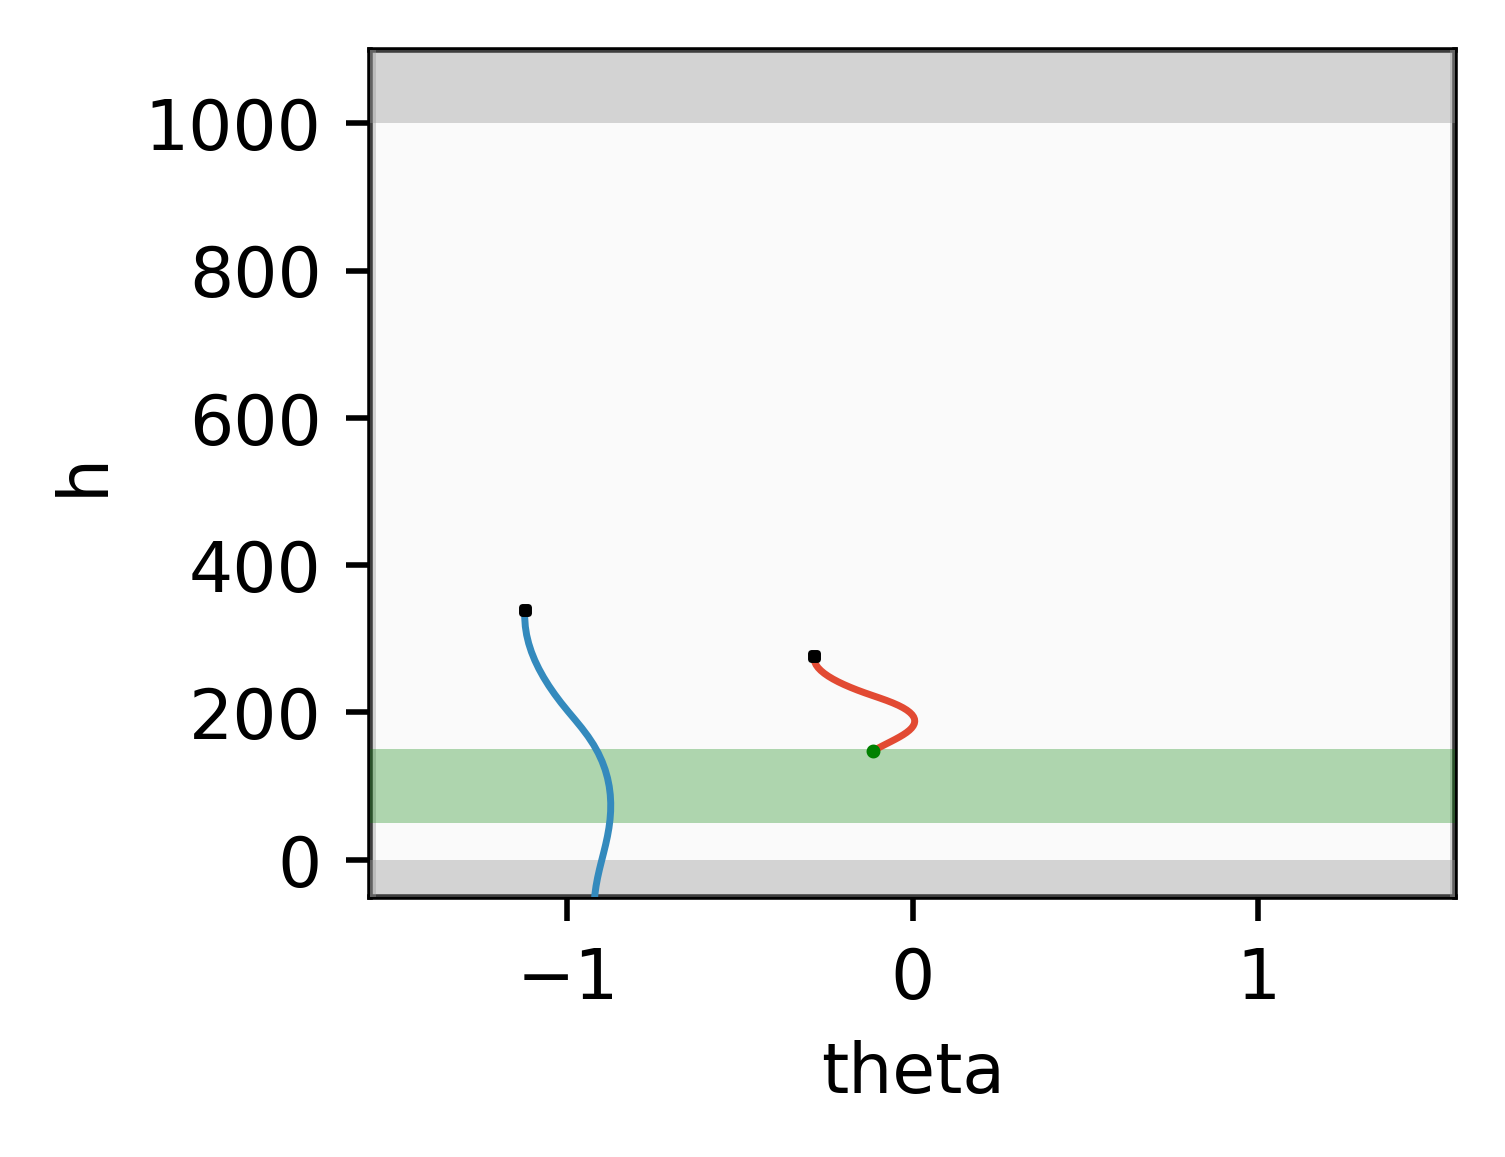

In [14]:
x0s, z0s = get_initial_states(task, alg, num = 2)
rollouts = generate_rollouts(task, alg, rootfind_pol, x0s, z0s)
plot_rollouts(plotter, bb_rollout=rollouts, fig_name='sim_trajs.jpg')

### Create a disturbed model

A time variant Gaussian noise disturbance is added to the $\theta$ state variable. The mean and std of the noise are proportional to the $\theta$ of current state $x_t$. 

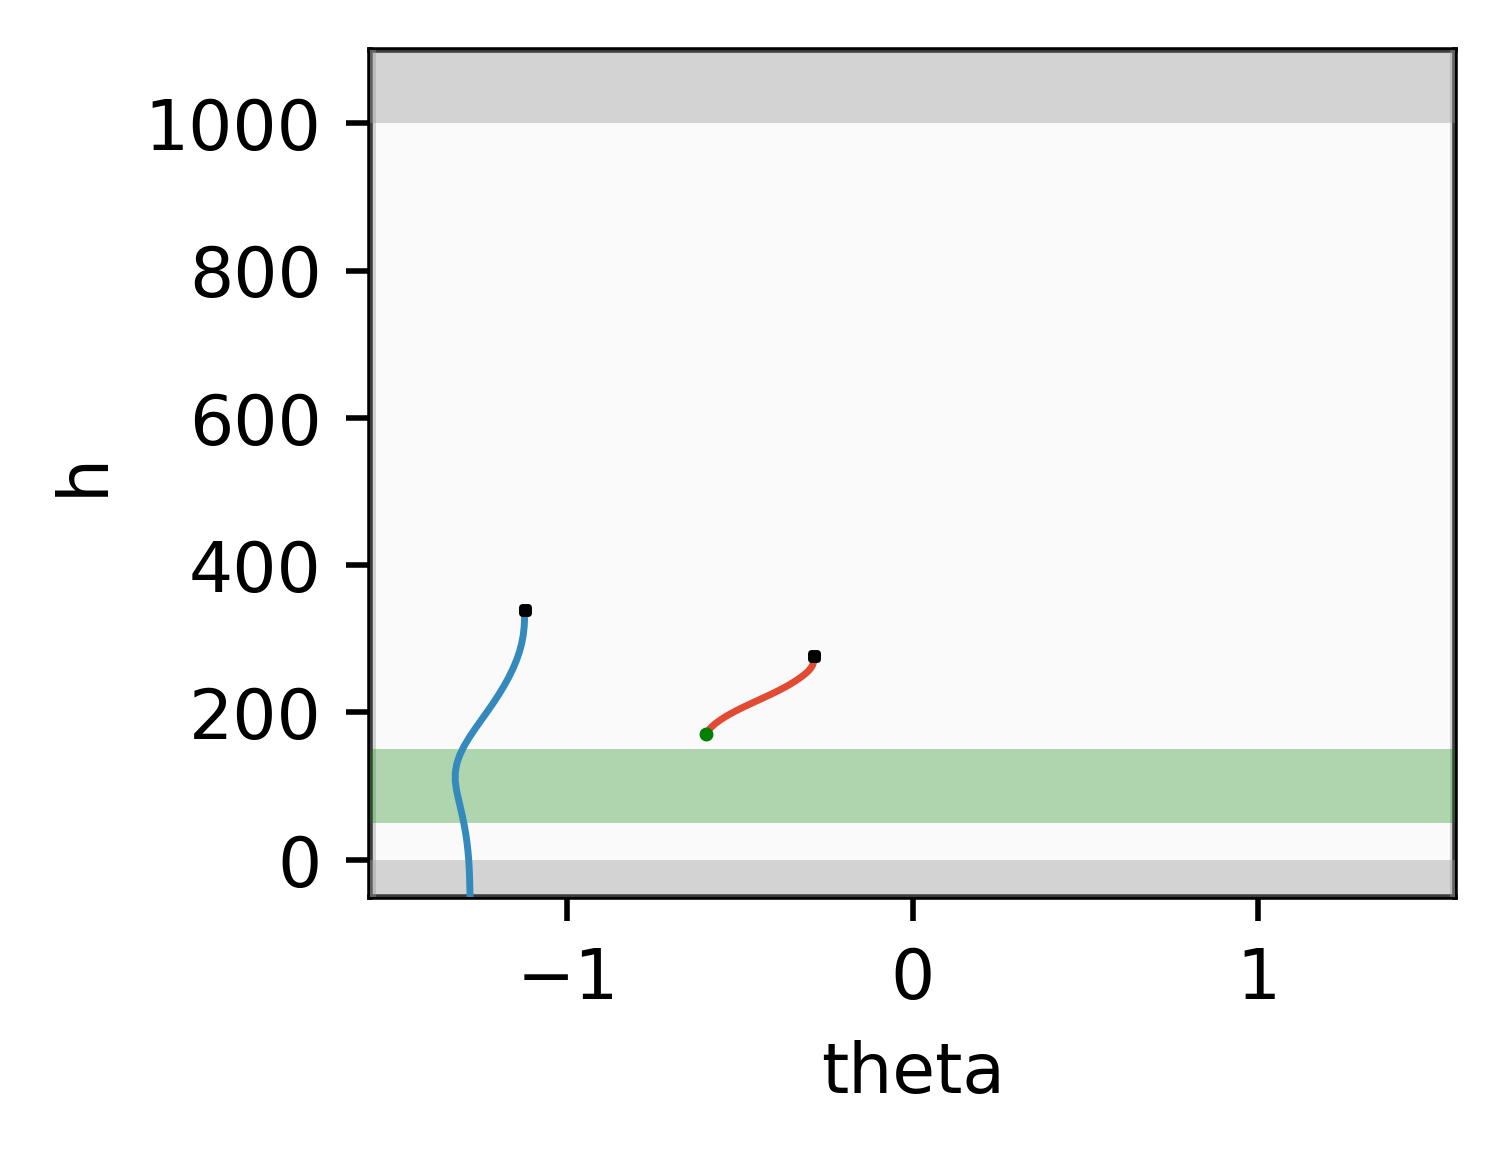

In [15]:
dist_task = F16GCASFloorCeilDisturbed()
dist_task.dt /= 2
dist_task.err_fn = lambda state_var: state_var[F16Safeguarded.THETA] + 0.5 * state_var[F16Safeguarded.THETA] + 0.5 * state_var[F16Safeguarded.THETA] * np.random.normal() 

dist_rollouts = generate_rollouts(dist_task, alg, rootfind_pol, x0s, z0s)
plot_rollouts(plotter, bb_rollout=dist_rollouts, fig_name='dist_trajs.jpg')

* Simulate from every measured state for T=512 steps

(2, 513, 17)
(2, 513)


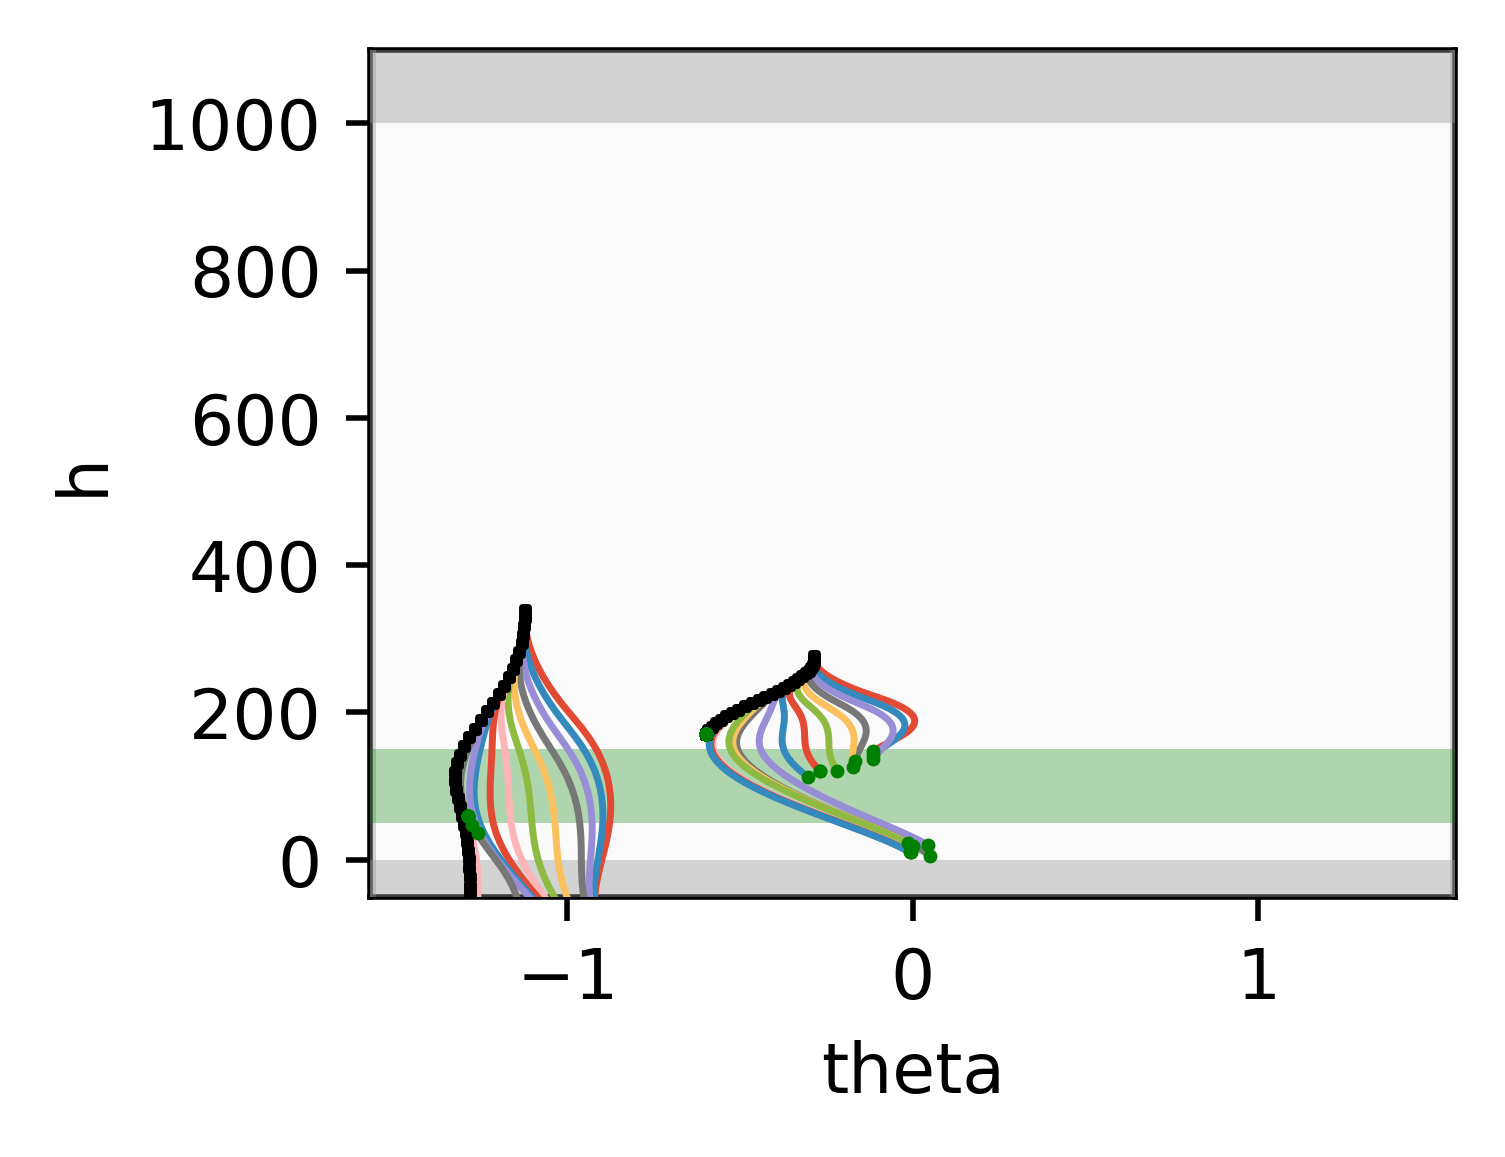

In [16]:
print(dist_rollouts.Tp1_state.shape)
print(dist_rollouts.Tp1_z.shape)
xms = dist_rollouts.Tp1_state.reshape(-1, 17)
zms = dist_rollouts.Tp1_z.reshape(-1)
bb_sims = generate_rollouts(task, alg, rootfind_pol, xms, zms, T = 512)
plot_rollouts(plotter, bb_rollout=bb_sims, fig_name='dist_sim_trajs.jpg')
   

## GP Regression

This notebook demonstrate how to fit a GP regression model with the difference between simulated and measured state errors

In [8]:
# Enable Float64 for more stable matrix inversions.
from jax import config

#config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import optax as ox
#from docs.examples.utils import clean_legend

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

key = jr.key(123)
 
 

/home/zwc662/anaconda3/envs/cbf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset

Create a dataset of disturbance errors.
From each step $t$ to the next step $t+1$, the measured states are $x_t$ and $x_{t+1}$. 
However, the simulated next state is $\hat{x}_{t+1}$.
Now build a dataset $D=\{x_t, y_t = \hat{x}_{t+1} - \hat{x}_{t+1}\}$

In [9]:
# Simulated states xs shape is (nx, T, dx) <= nx: number of measured states, T: simulation length: dx: dim of each state 
# Get 1st simulated step state for each measured states. Ignore the last state because there is no next state
xs = bb_sims.Tp1_state[:-1, 1, :]
print(xs.dtype, xs.shape) 
# Measured states xms shape is (num_traj, T, dx) <= num_traj: num of trajectories, T: simulation length, dx: dim of each state
# Flatten the trajectories. Ignore the last state because there is no next state
xms = dist_rollouts.Tp1_state.reshape(-1, 17)
#print(xms.dtype, xms.shape) 

cur_xms = xms[:-1]
nxt_xms = xms[1:,:]

assert xs.shape[0] == cur_xms.shape[0] == nxt_xms.shape[0]

X = cur_xms[:]
y = nxt_xms[:,F16Safeguarded.THETA:F16Safeguarded.THETA+1] - xs[:, F16Safeguarded.THETA: F16Safeguarded.THETA+1]


print(X.dtype, X.shape)
print(y.dtype, y.shape)

D = gpx.Dataset(X= X[::2], y = y[::2])

float32 (1025, 17)
float32 (1025, 17)
float32 (1025, 1)


/home/zwc662/anaconda3/envs/cbf/lib/python3.10/site-packages/jaxtyping/_decorator.py:457: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  out = fn(*args, **kwargs)
/home/zwc662/anaconda3/envs/cbf/lib/python3.10/site-packages/jaxtyping/_decorator.py:457: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  out = fn(*args, **kwargs)


### Constructing the prior 

* Define GP prior that is invariant w.r.t $x_t$. After creating the prior, it can be added to the low fidelity model to compensate the $\theta$. Need to define a new adaptive task to simulate the trajectories.

In [10]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)


#@jax.jit
#def get_dist_state(state): 
#    prior_dist = prior.predict(state.reshape(1, -1))
#    dist_theta = prior_dist.sample(seed=key, sample_shape=(1, 1))
#    dist_state = state.at[F16Safeguarded.THETA].add(jnp.asarray(dist_theta)[0, 0])
#    return dist_state 
       
#ada_task = F16GCASFloorCeilDisturbed()
#ada_task.dt /= 2
#ada_task.get_dist_state = get_dist_state
  
#bb_sims = generate_rollouts(ada_task, alg, rootfind_pol, xms, zms, T = 512)
#plot_rollouts(plotter, bb_rollout=bb_sims, fig_name='adv_sim_trajs.jpg')



### Contructing the posterior and optimize the parameters

* Get posterior from likelihood and prior. 
* Build marginal negative log-likelihood PyTree with the computed posterior. 
* JIT compute the negative log-likelihood. 
* Define optimizer to minimize the negative log-likelihood.



In [11]:
# Define likelihood
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)

posterior = prior * likelihood
 
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll = jit(negative_mll)

opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=D,
)

 

         Current function value: -802.200134
         Iterations: 19
         Function evaluations: 99
         Gradient evaluations: 87


/home/zwc662/anaconda3/envs/cbf/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


### Load the error model back to F16

In [17]:
@jax.jit
def get_dist_state(state): 
    print(state.shape)
    latent_dist = opt_posterior.predict(state.reshape(1, -1), train_data=D)
    posterior_dist = opt_posterior.likelihood(latent_dist)
    dist_theta = posterior_dist.mean()
    dist_state = state.at[F16Safeguarded.THETA].add(jnp.asarray(dist_theta)[0])
    return dist_state

(17,)


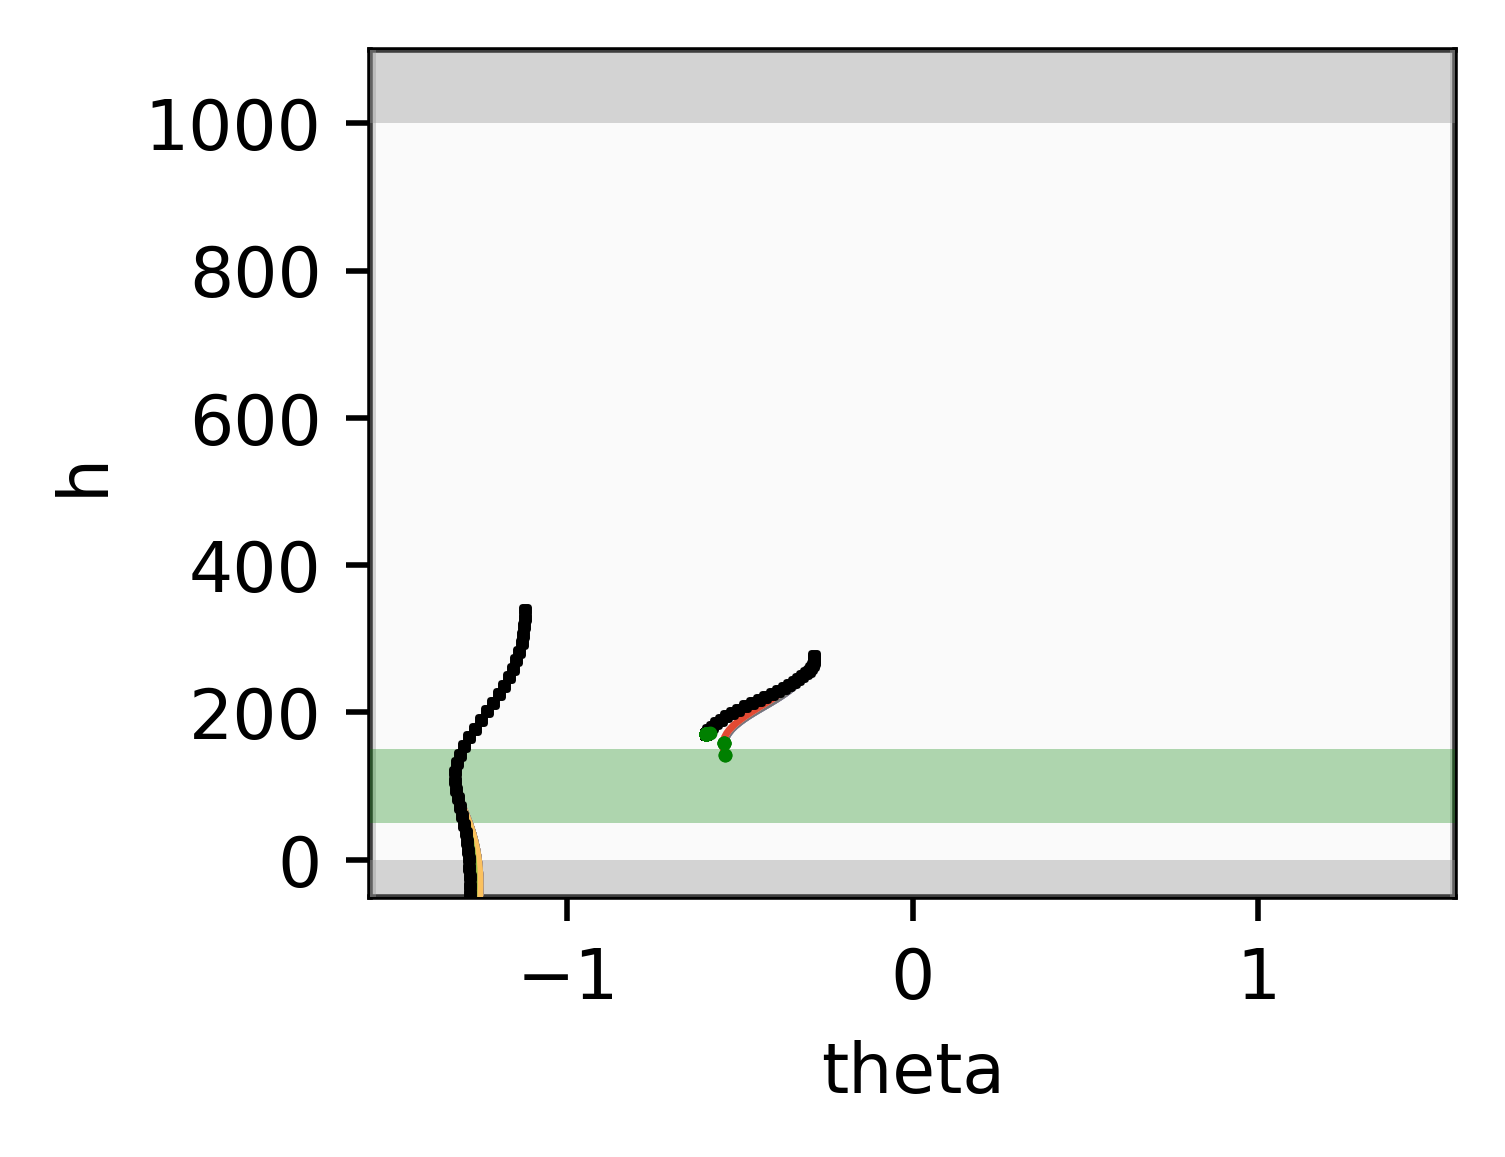

In [18]:

ada_task = F16GCASFloorCeilDisturbed()
ada_task.dt /= 2 
ada_task.get_dist_state = get_dist_state

bb_sims = generate_rollouts(ada_task, alg, rootfind_pol, xms, zms, T = 512)
plot_rollouts(plotter, bb_rollout=bb_sims, fig_name='ada_sim_trajs.jpg')
